# Directed Graph
- 5 nodes
- skip connection: $t_0=2$
- graph weights: all 1

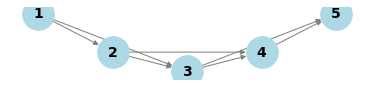

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# 创建一个有向图
G = nx.DiGraph()

# 添加节点
nodes = [1, 2, 3, 4, 5]
G.add_nodes_from(nodes)

# 添加有向边（连线）
edges = [(1, 2), (2, 3), (3, 4), (4,5), (1, 3), (2, 4), (3,5)]#, (1,4), (2,5)]
G.add_edges_from(edges)

# 手动设置节点位置，使其沿 x 轴排成直线
pos = {1: (0, 0), 2: (1, -0.2), 3: (2, -0.3), 4: (3, -0.2), 5: (4, 0)}

# 绘图
plt.figure(figsize=(5, 1))  # 设置图像大小

# 绘制图形
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='lightblue', edge_color='gray', font_size=14, font_weight='bold', arrows=True)

# 显示图
plt.show()


Normalized Laplacian Matrix
$$
\mathbf{L}^d_r = \begin{bmatrix}
0\\
-1 & 1\\
-1/2 & -1/2 & 1\\
 & -1/2 & -1/2 & 1\\
 & & -1/2& -1/2  &1
\end{bmatrix}
$$

Save graph weights in time-connection list and matrix: `(5, 2)`

In [2]:
import torch
d_ew = torch.ones(5,2)
d_ew = torch.tril(d_ew, diagonal=-1)
d_ew[0,0] = 1
degree = d_ew.sum(1)
d_ew = d_ew / degree[:,None]
d_ew[0,0] = 0
print(d_ew)

tensor([[0.0000, 0.0000],
        [1.0000, 0.0000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000]])


In [3]:
time_list = torch.arange(0,5).reshape(-1, 1) - torch.arange(1,3)
print(time_list)

tensor([[-1, -2],
        [ 0, -1],
        [ 1,  0],
        [ 2,  1],
        [ 3,  2]])


In [7]:
W = torch.zeros(5,5)
# Ldr.diagonal(0).fill_(1)
W.diagonal(-1).fill_(1)
W.diagonal(-2).fill_(1)
print(W)
W[0,0] = 1
Wdr = W / W.sum(1, keepdim=True)
# Ldr[0,0] = 0
# Ldr =
Ldr = torch.eye(5) - Wdr

print(Ldr)


tensor([[0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [0., 1., 1., 0., 0.],
        [0., 0., 1., 1., 0.]])
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.0000,  1.0000,  0.0000,  0.0000,  0.0000],
        [-0.5000, -0.5000,  1.0000,  0.0000,  0.0000],
        [ 0.0000, -0.5000, -0.5000,  1.0000,  0.0000],
        [ 0.0000,  0.0000, -0.5000, -0.5000,  1.0000]])


In [ ]:
# L^d_r x

# signal
x = torch.Tensor([1, 2, 3, 4, 5])

features = (d_ew.view(-1) * x[time_list.view(-1)]).reshape(-1, 2) # in (T, t_0)
y = x - features.sum(1)
y[0] = 0
print(y)

print(Ldr @ x)

tensor([0.0000, 1.0000, 1.5000, 1.5000, 1.5000])
tensor([0.0000, 1.0000, 1.5000, 1.5000, 1.5000])


In [10]:
# Ldr.T x
features = d_ew * x[:, None] # (T, t_0)
features = torch.stack([features.diagonal(offset=-offset, dim1=0, dim2=1).sum(-1) for offset in range(1, 5)], dim=0) # [(1)] * 4
y = x.clone()
y[0] = x[0] * 0
y[:-1] = y[:-1] - features
print(y)
print(Ldr.T @ x)

tensor([-3.5000, -1.5000, -1.5000,  1.5000,  5.0000])
tensor([-3.5000, -1.5000, -1.5000,  1.5000,  5.0000])


## define functions for such situations

In [12]:
def trim_weight_matrix(W:torch.Tensor, skip:int):
    assert W.dim() == 2 and W.size(0) == W.size(1), 'W should be a square matrix'
    mask = torch.zeros_like(W)
    for i in range(skip):
        mask.diagonal(-i-1).fill_(1)
    return W * mask

W = torch.ones(5,5)
W = trim_weight_matrix(W, 2)
print(W)

def normalized_Laplacian_matrix(W:torch.Tensor):
    assert W.dim() == 2 and W.size(0) == W.size(1), 'W should be a square matrix'
    W[0,0] = 1
    degree = W.sum(1)
    W = W / degree[:,None]
    return torch.eye(W.size(0)) - W

Ldr = normalized_Laplacian_matrix(W)
print(Ldr)

tensor([[0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [0., 1., 1., 0., 0.],
        [0., 0., 1., 1., 0.]])
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.0000,  1.0000,  0.0000,  0.0000,  0.0000],
        [-0.5000, -0.5000,  1.0000,  0.0000,  0.0000],
        [ 0.0000, -0.5000, -0.5000,  1.0000,  0.0000],
        [ 0.0000,  0.0000, -0.5000, -0.5000,  1.0000]])


In [ ]:
def directed_edge_weights(d_ew:torch.Tensor):
    N, T, skip = d_ew.size()
    d_ew = d_ew.tril(diagonal=-1)
    d_ew.tril
    
    d_ew[:,0,0].fill_(1)
    # print(d_ew)
    degree = d_ew.sum(-1, keepdim=True)
    d_ew = d_ew / degree
    d_ew[:,0,0].fill_(0)
    d_ew = d_ew.permute(1,2,0)
    return d_ew # (T, skip, N)

d_ew = torch.ones(7,5,2) # * torch.arange(1, 8)[:,None,None] # 7 nodes
d_ew = directed_edge_weights(d_ew)
print(d_ew.permute(2,0,1))

tensor([[[0.0000, 0.0000],
         [1.0000, 0.0000],
         [0.5000, 0.5000],
         [0.5000, 0.5000],
         [0.5000, 0.5000]],

        [[0.0000, 0.0000],
         [1.0000, 0.0000],
         [0.5000, 0.5000],
         [0.5000, 0.5000],
         [0.5000, 0.5000]],

        [[0.0000, 0.0000],
         [1.0000, 0.0000],
         [0.5000, 0.5000],
         [0.5000, 0.5000],
         [0.5000, 0.5000]],

        [[0.0000, 0.0000],
         [1.0000, 0.0000],
         [0.5000, 0.5000],
         [0.5000, 0.5000],
         [0.5000, 0.5000]],

        [[0.0000, 0.0000],
         [1.0000, 0.0000],
         [0.5000, 0.5000],
         [0.5000, 0.5000],
         [0.5000, 0.5000]],

        [[0.0000, 0.0000],
         [1.0000, 0.0000],
         [0.5000, 0.5000],
         [0.5000, 0.5000],
         [0.5000, 0.5000]],

        [[0.0000, 0.0000],
         [1.0000, 0.0000],
         [0.5000, 0.5000],
         [0.5000, 0.5000],
         [0.5000, 0.5000]]])


In [45]:
time_list = torch.arange(0,5).reshape(-1, 1) - torch.arange(1,2 + 1)
print(time_list)
x = torch.arange(1,6).float()[None, :, None, None].repeat(1, 1, 7, 1)
# print(d_ew)
def apply_op_Ldr(d_ew, time_list, x):
    B, T, N, C = x.size()
    print(B, T, N, C)
    print(d_ew.size(), x[:,time_list.view(-1)].size())
    features = (d_ew.view(-1,N)[None, :, :, None] * x[:,time_list.view(-1),:,:]).reshape(B, T, -1, N, C)
    assert torch.all(features[:,0] == 0), "Features at time 0 should be all zero"
    print(features.size())
    print(features[0,:,:,0,0])
    # print(features.sum(2).size())
    y = x - features.sum(2)
    y[:,0] = y[:,0] * 0
    return y

print(apply_op_Ldr(d_ew, time_list, x)[0,:,0,0])
print(torch.einsum('ij,bjnc->binc', Ldr, x)[0,:,0,0])
print(Ldr @ torch.arange(1,6).float())

tensor([[-1, -2],
        [ 0, -1],
        [ 1,  0],
        [ 2,  1],
        [ 3,  2]])
1 5 7 1
torch.Size([5, 2, 7]) torch.Size([1, 10, 7, 1])
torch.Size([1, 5, 2, 7, 1])
tensor([[0.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.5000],
        [1.5000, 1.0000],
        [2.0000, 1.5000]])
tensor([0.0000, 1.0000, 1.5000, 1.5000, 1.5000])
tensor([0.0000, 1.0000, 1.5000, 1.5000, 1.5000])
tensor([0.0000, 1.0000, 1.5000, 1.5000, 1.5000])


In [47]:
def apply_op_Ldr_T(d_ew, x):
    # d_ew: (T, skip, N)
    B, T, N, C = x.size()
    features = d_ew[None, :,:,:, None] * x[:, :, None, :,:] # (B, T, skip, N, C)
    features = torch.stack([features.diagonal(offset=-offset, dim1=1, dim2=2).sum(-1) for offset in range(1, T)], dim=1) # [(B, N, C)] * (T-1) -> (B, T-1, N, C)
    y = x.clone()
    y[:,0] = x[:,0] * 0
    y[:,:-1] = y[:,:-1] - features
    return y

print(apply_op_Ldr_T(d_ew, x)[0,:,0,0])
print(torch.einsum('ij,bjnc->binc', Ldr.T, x)[0,:,0,0])
print(Ldr.T @ torch.arange(1,6).float())


tensor([-3.5000, -1.5000, -1.5000,  1.5000,  5.0000])
tensor([-3.5000, -1.5000, -1.5000,  1.5000,  5.0000])
tensor([-3.5000, -1.5000, -1.5000,  1.5000,  5.0000])
